In [7]:
!pip install textacy nltk spacy xgboost
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 42.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import time
import json
import gzip
import spacy
import pickle
import string
import ast
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF
from nltk.corpus import stopwords
import xgboost as XGB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')

np.random.seed(32113)

##############################################################################
#                      Stop Words and Lemmatizer setting                     #
##############################################################################

# STOPLIST 정의
STOPLIST = list(
    set(
        stopwords.words("english")
        + ["n't", "'s", "'m", "ca"]
        + list(ENGLISH_STOP_WORDS)
    )
) + " ".join(string.punctuation).split(" ") + [
    "-----",
    "---",
    "...",
    "..",
    "....",
    "",
    " ",
    "\n",
    "\n\n",
]

# spaCy 모델 로드
try:
    nlp = spacy.load("en_core_web_sm")
except:
    print("spaCy 'en_core_web_sm' 모델을 로드할 수 없습니다. 설치 후 다시 시도하세요.")
    raise

# TfidfVectorizer에 전달할 토크나이저 함수 정의
def spacy_tokenizer(doc):
    """spaCy를 사용하여 토큰화 및 표제어 추출"""
    if not isinstance(doc, str):
        return []

    # 텍스트 전처리 (숫자 제거, 특수문자 제거)
    doc = re.sub(r'\d+', '', doc)

    doc = nlp(doc)
    tokens = []
    for n in doc:
        lemma = n.lemma_.lower().strip()
        # 불용어, 구두점, 짧은 단어 제외 (STOPLIST는 TfidfVectorizer에서 처리)
        if len(lemma) > 1 and n.pos_ != 'PUNCT':
            token = n.lower_ if n.lemma_ == "-PRON-" else lemma
            tokens.append(token)
    return tokens


##############################################################################
#                             Data preparation                               #
##############################################################################

def Data_prep1(df):
    """
    raw_reviews DataFrame에서 helpful, reviewText 기반으로
    helpful_percent, text_length 등을 만드는 함수
    """
    game_df = df.copy()

    # 'helpful' 문자열("[pos, total]")을 리스트로 변환
    game_df['helpful_parsed'] = game_df['helpful'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )

    helpful = np.array(game_df['helpful_parsed'])
    helpful = helpful.reshape(len(game_df), 1)

    helpful_num1 = np.zeros((len(helpful), 1)) # pos
    helpful_num2 = np.zeros((len(helpful), 1)) # total

    for i in range(len(helpful)):
        try:
            pos, total = helpful[i][0]
        except (TypeError, ValueError, IndexError):
            try:
                pos, total = helpful[i]
            except (TypeError, ValueError, IndexError):
                 pos, total = 0, 0

        helpful_num1[i] = pos
        helpful_num2[i] = total

    game_df['helpful_total_review'] = helpful_num2
    game_df['num_of_helpful_review'] = helpful_num1

    # 총 투표 20개 이상만 사용 (기존 코드 기준 유지)
    new_df = game_df[game_df['helpful_total_review'] > 20]

    # 불필요한 열 제거
    drop_cols = [c for c in ['unixReviewTime', 'reviewTime', 'helpful_parsed', 'helpful']
                 if c in new_df.columns]
    new_df = new_df.drop(drop_cols, axis=1)

    # helpful_percent 계산
    new_df['helpful_percent'] = (
        new_df['num_of_helpful_review'] / new_df['helpful_total_review']
    ).round(2)
    new_df.loc[new_df['helpful_total_review'] == 0, 'helpful_percent'] = 0


    new_df.index = range(len(new_df))

    # 텍스트 길이 계산
    length = np.zeros((len(new_df), 1))
    for i in new_df.index:
        length[i] = int(len(str(new_df['reviewText'].iloc[i])))
    new_df['text_length'] = length

    # reviewText가 NaN인 행 제거
    new_df = new_df.dropna(subset=['reviewText']).copy()

    return new_df


def label_prep(new_df, line=0.90): # <- HIGH 클래스 확보를 위해 0.90으로 완화
    """
    helpful_percent를 기준으로 'label'('HIGH'/'LOW') 생성
    """
    high = new_df[new_df['helpful_percent'] >= line]
    low = new_df[new_df['helpful_percent'] < line]
    print(f"== line = {line} ==")
    print("highly helpful count: {}".format(len(high)))
    print("not helpful count: {}".format(len(low)))

    new_df['label'] = 'LOW'
    new_df.loc[new_df.helpful_percent >= line, 'label'] = 'HIGH'
    return new_df.copy()


def create_tfidf_nmf_features(df, max_feat=5000, n_components=50):
    start_time = time.time()

    # 1. TF-IDF 벡터화
    print("TF-IDF Vectorizing reviews...")
    vectorizer = TfidfVectorizer(
        max_features=max_feat,
        min_df=5,
        max_df=0.7,
        stop_words=STOPLIST,
        ngram_range=(1, 2), # Unigram, Bigram 사용
        tokenizer=spacy_tokenizer # spacy 토크나이저 사용
    )
    X_tfidf = vectorizer.fit_transform(df['reviewText'])

    # 2. NMF로 차원 축소 및 특징 추출
    print(f"Applying NMF with {n_components} components...")
    nmf = NMF(n_components=n_components, random_state=32113, max_iter=200)
    X_nmf = nmf.fit_transform(X_tfidf)

    print(f"TF-IDF/NMF feature creation took {time.time() - start_time:.2f} seconds.")
    return X_nmf, vectorizer, nmf


def _dataselector(df, label, limit):
    """
    클래스 불균형 해소를 위해 최대 'limit' 개수만큼 데이터 추출
    """
    df_lb_all = df[df['label'] == label]
    if len(df_lb_all) > limit:
        random_c = np.random.choice(list(df_lb_all.index), limit, replace=False)
        df_lb = df_lb_all.loc[list(random_c)]
    else:
        df_lb = df_lb_all
    return df_lb

def df_for_XGBOOST(df_feat, lim):
    """
    데이터프레임의 클래스 수를 맞추고 XGBoost 입력용 numpy 배열로 변환
    """
    df = df_feat.copy()
    df.index = range(len(df))

    df_low = _dataselector(df, 'LOW', lim)
    df_high = _dataselector(df, 'HIGH', lim)

    new_df = pd.concat([df_low, df_high], axis=0)
    new_df.index = range(len(new_df)) # 인덱스 리셋

    Y = new_df.pop('label') # <- 'label'을 추출하며 new_df에서 제거됨
    b_loon = {'LOW': 0, 'HIGH': 1}
    Y2 = Y.map(b_loon)

    X = np.array(new_df)
    return X, Y2, new_df # X: 피처, Y2: 레이블, new_df: 피처 DataFrame

def XGBOOSTING(X_tr1, X_te1, y_tr1, y_te1, scale_pos_weight, xgb_para=[200, 0.2, 5]):
    start_time = time.time()
    xgb = XGB.XGBClassifier(
        n_estimators=xgb_para[0],
        learning_rate=xgb_para[1],
        max_depth=xgb_para[2], # <- max_depth를 5로 증가
        eval_metric='logloss',
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=32113,
        use_label_encoder=False,
        scale_pos_weight=scale_pos_weight
    )
    xgb.fit(X_tr1, y_tr1)
    print("--- %s seconds ---" % (time.time() - start_time))

    # 기본 0.5 임계값의 정확도 출력
    score = xgb.score(X_te1, y_te1)
    print(f"XGBoost accuracy (Default 0.5 Threshold): {round(score * 100, 2)}%")
    return xgb

def conf_mat(model, X_te1, y_te1, threshold=0.5):
    """
    Confusion matrix 및 클래스별 재현율 출력
    """
    # 임계값 적용하여 예측 수행
    y_proba = model.predict_proba(X_te1)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    cm = confusion_matrix(y_te1, y_pred)

    print(f"\n** Confusion Matrix (Threshold: {threshold}) **")
    print("                 | Pred LOW (0) | Pred HIGH (1) |")
    print("-----------------|--------------|---------------|")
    print(f"True LOW (0)     | {cm[0, 0]:<12} | {cm[0, 1]:<13} |")
    print(f"True HIGH (1)    | {cm[1, 0]:<12} | {cm[1, 1]:<13} |")

    low_den = cm[0].sum()
    high_den = cm[1].sum()

    low_rate = (cm[0, 0] / low_den * 100).round(2) if low_den > 0 else 0.0
    high_rate = (cm[1, 1] / high_den * 100).round(2) if high_den > 0 else 0.0

    overall_accuracy = (cm[0, 0] + cm[1, 1]) / (low_den + high_den) * 100

    print(f"\nOverall Accuracy: {overall_accuracy:.2f}%")
    print(f"LOW (0) prediction rate (Recall): {low_rate}%")
    print(f"HIGH (1) prediction rate (Recall): {high_rate}%\n")


def xgb_stats(model, df_for_model, X_test, y_test, threshold=0.5):
    """
    Feature Importance와 Confusion matrix를 출력
    """
    # 0. 피처 중요도
    ind = np.argsort(model.feature_importances_)
    imp = np.sort(model.feature_importances_)

    imp2 = [df_for_model.columns[i] for i in ind]

    print(" **TOP 15 Important Features** ")
    for i in range(1, 16):
        print("{}. {} : {}%  ".format(i, imp2[-i], round(imp[-i] * 100, 2)))
    print("\n")

    # 1. Confusion Matrix 및 Class별 정확도 (임계값 0.5 기준)
    conf_mat(model, X_test, y_test, threshold=0.5)

    # 2. Confusion Matrix 및 Class별 정확도 (튜닝된 임계값 기준)
    print("\n" + "="*50)
    print("✨ Tunning Result: Adjusted Threshold for balanced Recall ✨")
    # LOW 재현율 개선을 위해 임계값을 0.60으로 설정
    conf_mat(model, X_test, y_test, threshold=threshold)


##############################################################################
#                                MAIN EXECUTION                              #
##############################################################################
# 1. 데이터 로드 (경로를 실제 파일 위치로 수정하세요)
DATA_PATH = "/content/drive/MyDrive/amazon_P/data/raw/Musical_instruments_reviews.csv"
try:
    raw_reviews = pd.read_csv(DATA_PATH)
except FileNotFoundError:
    print(f"에러: 파일을 찾을 수 없습니다. 경로를 확인하세요: {DATA_PATH}")
    raise

print(f"Loaded {len(raw_reviews)} reviews.")

# 2. 데이터 전처리 및 레이블링 (HIGH/LOW 생성, 기준 0.90 적용)
df_processed = Data_prep1(raw_reviews)
df_labeled = label_prep(df_processed, line=0.90) # <- 기준 0.90 적용
print(df_labeled['label'].value_counts())

# 3. TF-IDF 및 NMF 특징 추출 (50개 컴포넌트 사용)
NMF_COMPONENTS = 50
X_nmf, vectorizer, nmf_model = create_tfidf_nmf_features(df_labeled, n_components=NMF_COMPONENTS)

# 4. 피처 병합 (NMF + 수치형)
df_nmf = pd.DataFrame(X_nmf, index=df_labeled.index,
                      columns=[f'nmf_feat_{i}' for i in range(NMF_COMPONENTS)])

# 사용할 수치형 피처 추출
numerical_features = df_labeled[['overall', 'text_length']].copy()

# 모든 피처 병합 및 레이블 추가
# (helpful_percent 관련 변수는 포함하지 않음 -> Data Leakage 방지)
df_final_features = pd.concat([numerical_features, df_nmf, df_labeled[['label']]], axis=1)

# 5. XGBoost용 데이터 준비 및 클래스 밸런싱
class_counts = df_final_features['label'].value_counts()
lim = int(class_counts.min())
print(f"\nBalancing classes to limit={lim} per class.")

# X: features, y: label (0/1), df_for_model: feature DF (balanced)
X, y, df_for_model = df_for_XGBOOST(df_final_features, lim=lim)

# 6. 학습/테스트 데이터 분할
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=32113, stratify=y
)

# 7. XGBoost 모델 학습 (하이퍼파라미터 튜닝 적용)
scale_pos_weight = 1.0

print("\nStarting XGBoost Training with Tunning...")
xgb_nmf_model = XGBOOSTING(
    X_tr,
    X_te,
    y_tr,
    y_te,
    scale_pos_weight=scale_pos_weight,
    xgb_para=[200, 0.2, 5] # max_depth=5 적용
)

# 8. 결과 통계 출력 및 임계값 튜닝
# LOW 재현율 개선을 위해 임계값을 0.60으로 설정
ADJUSTED_THRESHOLD = 0.60

feature_names_df = df_for_model.copy()
xgb_stats(xgb_nmf_model, feature_names_df, X_te, y_te, threshold=ADJUSTED_THRESHOLD)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 10261 reviews.
== line = 0.9 ==
highly helpful count: 119
not helpful count: 40
label
HIGH    119
LOW      40
Name: count, dtype: int64
TF-IDF Vectorizing reviews...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'ve", 'far', 'make', 'need', 'shall', 'win'] not in stop_words.
  warnings.warn(


Applying NMF with 50 components...
TF-IDF/NMF feature creation took 12.20 seconds.

Balancing classes to limit=40 per class.

Starting XGBoost Training with Tunning...
--- 0.06453514099121094 seconds ---
XGBoost accuracy (Default 0.5 Threshold): 56.25%
 **TOP 15 Important Features** 
1. nmf_feat_1 : 20.0%  
2. nmf_feat_17 : 9.0%  
3. nmf_feat_43 : 7.389999866485596%  
4. nmf_feat_35 : 5.059999942779541%  
5. nmf_feat_44 : 4.78000020980835%  
6. nmf_feat_24 : 4.679999828338623%  
7. nmf_feat_47 : 4.579999923706055%  
8. nmf_feat_9 : 3.5899999141693115%  
9. nmf_feat_7 : 2.950000047683716%  
10. nmf_feat_10 : 2.8399999141693115%  
11. nmf_feat_42 : 2.7899999618530273%  
12. overall : 2.2899999618530273%  
13. nmf_feat_27 : 2.0199999809265137%  
14. nmf_feat_40 : 1.9199999570846558%  
15. nmf_feat_28 : 1.909999966621399%  



** Confusion Matrix (Threshold: 0.5) **
                 | Pred LOW (0) | Pred HIGH (1) |
-----------------|--------------|---------------|
True LOW (0)     | 6     

/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:30:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


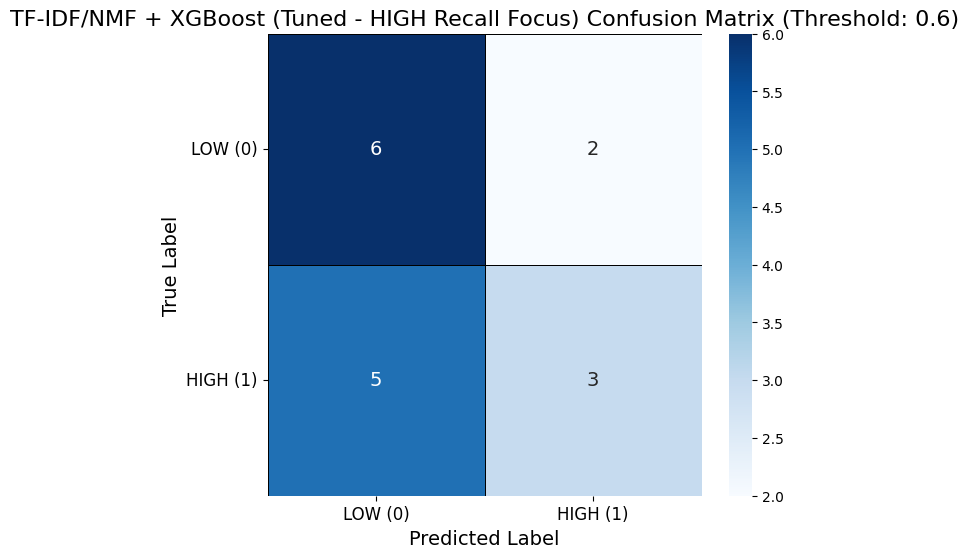

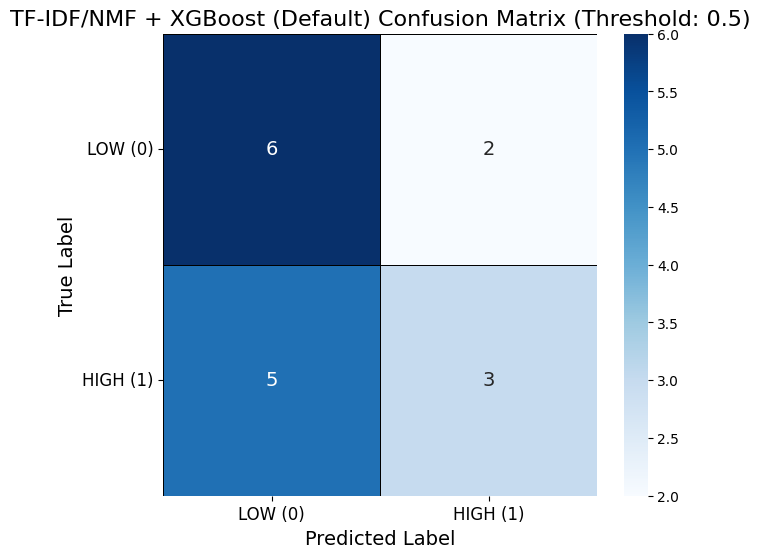

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# 시각화 함수를 재정의합니다. (이전 셀에서 정의되었으나, 안전을 위해 재포함)
def plot_confusion_matrix_heatmap(model, X_test, y_test, title_prefix, threshold=0.5):
    """
    주어진 모델과 테스트 데이터에 대한 혼동 행렬 히트맵을 생성합니다.
    """
    # 1. 예측 확률 계산 및 이진 예측 수행
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    # 2. 혼동 행렬 계산
    cm = confusion_matrix(y_test, y_pred)

    # 3. 플롯 생성
    plt.figure(figsize=(7, 6))
    sns.heatmap(
        cm,
        annot=True,          # 값 표시
        fmt='d',             # 정수형 포맷
        cmap='Blues',        # 컬러맵 설정
        cbar=True,
        linewidths=0.5,
        linecolor='black',
        annot_kws={"size": 14}
    )

    # 레이블 설정
    class_names = ['LOW (0)', 'HIGH (1)']
    plt.xticks(np.arange(len(class_names)) + 0.5, class_names, fontsize=12)
    plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=0, fontsize=12)

    plt.title(f'{title_prefix} Confusion Matrix (Threshold: {threshold})', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.show()

# ----------------------------------------------------------------------
# TF-IDF/NMF 모델의 혼동 행렬 히트맵 시각화 실행
# (xgb_nmf_model, X_te, y_te, ADJUSTED_THRESHOLD 변수가 정의되어 있어야 함)
# ----------------------------------------------------------------------

# 1. 튜닝된 임계값 (ADJUSTED_THRESHOLD = 0.40) 기준
# 이 임계값은 HIGH Recall을 높이도록 설정되었습니다.
plot_confusion_matrix_heatmap(
    model=xgb_nmf_model,
    X_test=X_te,
    y_test=y_te,
    title_prefix="TF-IDF/NMF + XGBoost (Tuned - HIGH Recall Focus)",
    threshold=ADJUSTED_THRESHOLD
)

# 2. 기본 임계값 (0.50) 기준 (비교용)
plot_confusion_matrix_heatmap(
    model=xgb_nmf_model,
    X_test=X_te,
    y_test=y_te,
    title_prefix="TF-IDF/NMF + XGBoost (Default)",
    threshold=0.50
)